# Corona-hack-chest -xray Predication

## Table of Contents
<ul>
    <li><a href="#sec1">Importing the data from Kaggle</a></li>
    <li><a href="#wrangling">Data Wrangling</a></li>
    <li><a href="#sec3">Image augmentation</a></li>
    <li><a href="#sec4">Pre-processing</a></li>
    <li><a href="#sec5">Deep Learning Model</a></li>
    <li><a href="#sec6">Evaluate on the testing data</a></li>
</ul>

<a id='sec1'></a>
## Importing the data from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamelmohamed","key":"fbeee9afdf8a16057073db98c46b1435"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-01 17:39:01          13207  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           7961  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3482  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           3069  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

### Downlad the data from kaggle

In [ ]:
! kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

 99% 1.18G/1.19G [00:24<00:00, 65.5MB/s]
100% 1.19G/1.19G [00:24<00:00, 51.4MB/s]


In [ ]:
! mkdir data
! unzip coronahack-chest-xraydataset.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflat

<a id='sec3'></a>
## Data Wrangling


In [ ]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
import datetime

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, auc

# Tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Import successfully")

Import successfully


### Importing the meta-data

#### The images are accessed with the meta-data

In [ ]:
train_path = '/content/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_path = '/content/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

df = pd.read_csv(r'/content/data/Chest_xray_Corona_Metadata.csv', index_col=0)
df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
# Split to train & test set
train_df = df[df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = df[df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

Shape of train data: (5286, 5)
Shape of test data: (624, 5)


### Handling the non-values in the meta-data

#### It's non important so much so we didn't need to drop it

In [ ]:
# fill na
train_df.fillna('unknow', inplace=True)
test_df.fillna('unknow', inplace=True)

<a id='sec3'></a>
## Image augmentation

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.8, 1.2),
                              zoom_range=[0.75, 1],
                              horizontal_flip=True)

test_datagen = ImageDataGenerator()

### Split the train data into train and validate

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train_path,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

valid_batches = test_datagen.flow_from_dataframe(valid_df,
                                             directory=train_path,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

test_batches = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_path,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            shuffle=False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
print(f'Label encode: { valid_batches.class_indices }')

Label encode: {'Normal': 0, 'Pnemonia': 1}


In [ ]:
train_batches_series = pd.Series(train_batches.classes)
valid_batches_series = pd.Series(valid_batches.classes)

print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in valid_batches: \n{ valid_batches_series.value_counts() }')

Value count in train_batches: 
1    3169
0    1059
dtype: int64
Value count in valid_batches: 
1    775
0    283
dtype: int64


<a id='sec4'></a>
## Pre-processing

### Creating a models directory

In [ ]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

In [ ]:
resize_and_rescale = Sequential([
    Resizing(224, 224),
    Rescaling(1./255)
])

In [ ]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC'),
           'accuracy']

<a id='sec5'></a>
## Deep Learning Model

In [ ]:
Model = Sequential([resize_and_rescale])

Model.add(keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu'))
Model.add(keras.layers.MaxPool2D(4,4))
Model.add(keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu')) 
Model.add(keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
Model.add(keras.layers.MaxPool2D(4,4))
Model.add(keras.layers.Flatten())
Model.add(keras.layers.Dense(120,activation='relu'))
Model.add(keras.layers.Dense(50,activation='relu'))  
Model.add(keras.layers.Dropout(rate=0.5))
Model.add(keras.layers.Dense(1,activation='sigmoid'))

### Model Training

In [ ]:
epochs = 10
lr = 1e-4

Model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=metrics)

In [ ]:
training_time_start = datetime.datetime.now()

Model_history = Model.fit(train_batches,
                                epochs=epochs,
                                verbose=1,
                                validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),
                                validation_steps=len(valid_batches))

training_time_end = datetime.datetime.now()

Epoch 1/10
34/34 [==============================] - 737s 22s/step - loss: 0.5816 - TP: 3093.0000 - TN: 24.0000 - FP: 1035.0000 - FN: 76.0000 - AUC: 0.7772 - accuracy: 0.7372 - val_loss: 0.5834 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.7602 - val_accuracy: 0.7325
Epoch 2/10
34/34 [==============================] - 749s 22s/step - loss: 0.5394 - TP: 3167.0000 - TN: 2.0000 - FP: 1057.0000 - FN: 2.0000 - AUC: 0.8461 - accuracy: 0.7495 - val_loss: 0.5369 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.9162 - val_accuracy: 0.7325
Epoch 3/10
34/34 [==============================] - 758s 22s/step - loss: 0.4805 - TP: 3159.0000 - TN: 57.0000 - FP: 1002.0000 - FN: 10.0000 - AUC: 0.9107 - accuracy: 0.7606 - val_loss: 0.4463 - val_TP: 770.0000 - val_TN: 46.0000 - val_FP: 237.0000 - val_FN: 5.0000 - val_AUC: 0.9538 - val_accuracy: 0.7713
Epoch 4/10
34/34 [==============================] - 775s 23s/step -

<a id='sec6'></a>

## Evaluate on the testing data

In [ ]:
evaluate_model = Model.evaluate(test_batches, verbose=1)

78/78 [==============================] - 28s 357ms/step - loss: 0.3656 - TP: 354.0000 - TN: 179.0000 - FP: 55.0000 - FN: 36.0000 - AUC: 0.9463 - accuracy: 0.8542


In [ ]:
total_training_seconds = (training_time_end - training_time_start).seconds
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))

Total training time:  2:11:15


In [ ]:
Model_history_df = pd.DataFrame(Model_history.history)

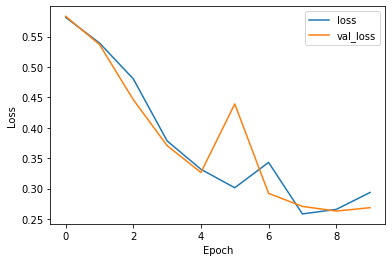

In [ ]:
Model_history_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

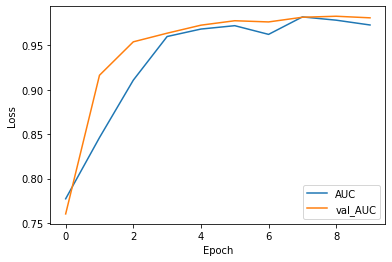

In [ ]:
Model_history_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()